In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

import kplr
import numpy as np
import matplotlib.pyplot as plt
# from astropy.table import Table
from scipy.signal import medfilt

import tensorflow as tf
session = tf.InteractiveSession()

from exoplanet import transit, kepler, interp

import hemcee
import tfmodeling as tfm

# import celeriteflow as cf

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
kepid = 11709124
client = kplr.API()
star = client.star(kepid)
t = []
y = []
yerr = []
quarter = []
texp = []
for i, lc in enumerate(star.get_light_curves(short_cadence=False)):
    with lc.open() as f:
        hdr = f[1].header
        texp0 = hdr["INT_TIME"] * hdr["NUM_FRM"] / (24. * 60. * 60.)
        data = f[1].data

    q = data["SAP_QUALITY"]
    t0 = data["TIME"]
    y0 = data["PDCSAP_FLUX"]
    m = (q == 0) & np.isfinite(t0) & np.isfinite(y0)
    mu = medfilt(y0[m], 101)
#     mu = np.median(y0[m])
    t.append(t0[m])
    y.append((y0[m] / mu - 1.0) * 1e3)
    yerr.append(data["PDCSAP_FLUX_ERR"][m] * 1e3 / mu)
    quarter.append(i + np.zeros(m.sum(), dtype=int))
    texp.append(texp0 + np.zeros(m.sum()))
t = np.ascontiguousarray(np.concatenate(t), dtype=np.float64)
y = np.ascontiguousarray(np.concatenate(y), dtype=np.float64)
yerr = np.ascontiguousarray(np.concatenate(yerr), dtype=np.float64)
quarter = np.ascontiguousarray(np.concatenate(quarter), dtype=int)
texp = np.median(np.concatenate(texp))

In [3]:
kois = star.kois
spec = np.empty(len(kois),
                dtype=[("period", float), ("ror", float), ("t0", float), ("duration", float)])
for i, koi in enumerate(kois):
    spec["period"][i] = koi.koi_period
    spec["ror"][i] = koi.koi_ror
    spec["t0"][i] = koi.koi_time0bk % koi.koi_period
    spec["duration"][i] = koi.koi_duration / 24.0
spec = spec[np.argsort(spec["period"])]

In [20]:
# gkf = Table.read("kepler_dr2_1arcsec.fits", format="fits").to_pandas()
# star = gkf[gkf.kepid.astype(int) == kepid].iloc[0]

# vals = dict()
# for k in ["radius", "mass"]:
#     mn = star[k] + star[k + "_err2"]
#     mx = star[k] + star[k + "_err1"]
#     log_mu = np.log(star[k])
#     log_err = 0.5 * ((log_mu - np.log(mn)) + (np.log(mx) - log_mu))
#     vals[k] = (log_mu, log_err)

# np.random.seed(42)
# N = 50000
# R = np.exp(vals["radius"][0] + vals["radius"][1] * np.random.randn(N))
# M = np.exp(vals["mass"][0] + vals["mass"][1] * np.random.randn(N))
# log_dens = np.log(0.75 * M / (np.pi * R**3))
# log_dens = (np.mean(log_dens), np.std(log_dens))
# print(log_dens)
log_dens = -1.4547524087769572, 0.3502230916468015

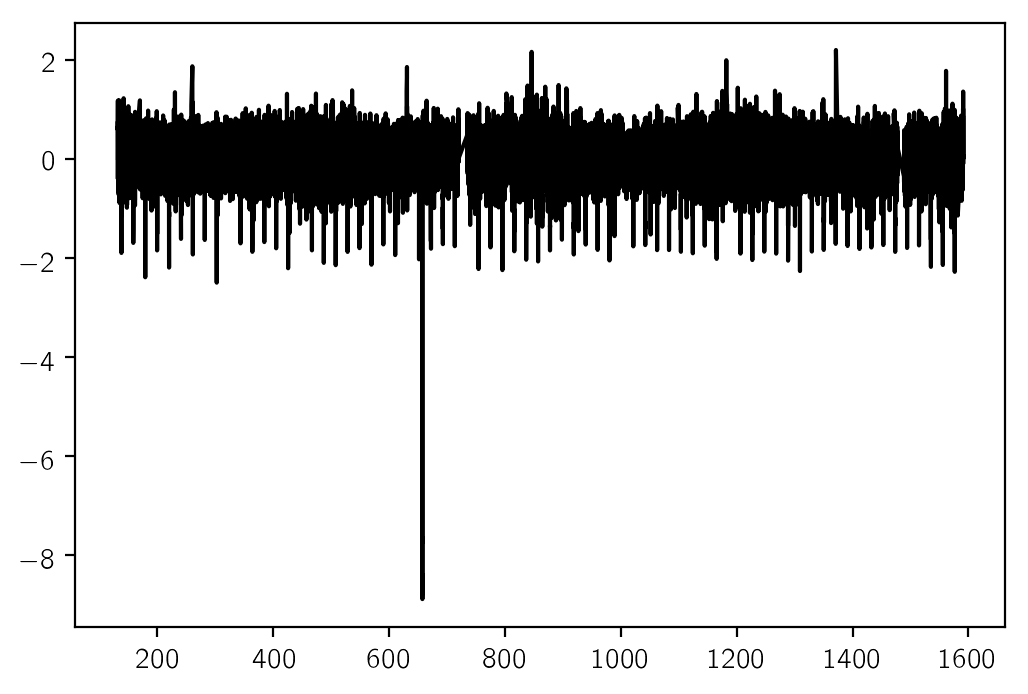

In [21]:
t0 = spec["t0"][-1]
tau = spec["duration"][-1]
rng = (t0 - 1000 < t) & (t < t0 + 1000)
plt.plot(t[rng], y[rng], "k")

In [6]:
spec

array([(  3.93276627, 0.014124,   0.93558682, 0.1225125 ),
       (  9.91937693, 0.012428,   7.92170991, 0.18025   ),
       ( 20.5498184 , 0.038064,  14.5478488 , 0.23118333),
       ( 33.0405509 , 0.022276,  29.0592564 , 0.14005417),
       ( 62.3026877 , 0.028719,  54.4941046 , 0.312875  ),
       (934.09418462, 0.086844, 657.26877   , 0.72870833)],
      dtype=[('period', '<f8'), ('ror', '<f8'), ('t0', '<f8'), ('duration', '<f8')])

In [7]:
T = tf.float64
np.random.seed(42)

G_grav = 2945.462538537765
factor = (G_grav / (3 * np.pi)) ** (1./3)

t_tensor = tf.constant(t[rng], dtype=T)
y_tensor = tf.constant(y[rng], dtype=T)
yerr_tensor = tf.constant(yerr[rng], dtype=T)

# Star
log_jitter = tfm.Parameter(
    2.0*np.log(np.median(yerr)),
    bounds=(2.0*np.log(0.01*np.median(yerr)), 2.0*np.log(10.0*np.median(yerr))),
    dtype=T)
flux = tfm.Parameter(0.0, bounds=(-2, 2), dtype=T)
q = tfm.Parameter(0.5 + np.zeros(2), bounds=(0, 1), dtype=T)
log_rho_star = tfm.Parameter(log_dens[0], dtype=T)
q1 = q.value[0]
q2 = q.value[1]
c1 = 2.0 * tf.sqrt(q1) * q2
c2 = tf.sqrt(q1) * (1.0 - 2.0 * q2)
ld = transit.QuadraticLimbDarkening(c1, c2)

# planets
pls = [2, 5]
n_pl = len(pls)
log_Ps = []
for p in spec["period"][pls]:
#     bounds = None
    bounds = (np.log(p - 1), np.log(p + 1))
    if p > 365:
        bounds = (np.log(10), np.log(100*365.))
    log_Ps.append(tfm.Parameter(np.log(p), bounds=bounds, dtype=T))
log_P = tf.stack([p.value for p in log_Ps])

log_r = tfm.Parameter(np.log(spec["ror"][pls]), dtype=T)  # bounds=(-10, 10), dtype=T)
t0 = tfm.Parameter(spec["t0"][pls], dtype=T)
b = tfm.Parameter(0.5 + np.zeros(n_pl), bounds=(-2.0, 2.0), dtype=T)
e = tfm.Parameter(np.random.uniform(0, 0.01, n_pl), bounds=(0, 1.0), dtype=T)
# e = tfm.Parameter(np.zeros(n_pl), dtype=T)
omega_vec = tfm.UnitVector(np.random.randn(n_pl, 2), dtype=T)

period = tf.expand_dims(tf.exp(log_P), 1)
ror = tf.exp(log_r.value)
a = factor * tf.exp((2.0 * log_P + log_rho_star.value) / 3.0)
cosi = tf.abs(b.value) / a
incl = tf.acos(cosi)

sin_omega = omega_vec.value[:, 0]
cos_omega = omega_vec.value[:, 1]
omega = tf.atan2(sin_omega, cos_omega)

# Set up the interpolation grid for each planet
nint = 7
dt = texp * np.linspace(-0.5, 0.5, 2*nint+1)[1:-1:2]
hp = 0.5 * period
grid = 1.5 * spec["duration"][pls][:, None] * np.linspace(-0.5, 0.5, int(np.ceil(5 * spec["duration"].max() / texp)))[None, :]
grid_phase = tf.constant(grid, dtype=T) + hp
grid = tf.constant(grid[:, :, None] + dt[None, None, :], dtype=T)

# Solve Kepler's equation on the grid
coords = a[None, :, None, None] * kepler.sky_position(
    period[:, :, None],
    tf.zeros((n_pl, 1, 1), dtype=T),  # <- t0
    e.value[:, None, None],
    omega[:, None, None],
    incl[:, None, None],
    grid)

# Compute the sky position and the transit light curve on the grid
d = tf.sqrt(tf.reduce_sum(tf.square(coords[:2]), axis=0))
delta = transit.transit_depth(ld, d, ror[:, None, None]+tf.zeros_like(d), direction=coords[2], n_integrate=100)
transit_grid = 1e3 * tf.reduce_mean(delta, axis=-1)

# Compute the time coordinate for each planet
arg = tf.add(t_tensor[None, :], (-t0.value[:, None] + hp))
phase = tf.mod(arg, period)   # - hp[:, None]
# p = period[:, None]  # -tf.ones(n_pl, dtype=T)
transit_model = flux.value - tf.reduce_sum(interp.interp1d(phase, grid_phase, transit_grid), axis=0)

# transit_model = flux.value - 1e3 * tf.reduce_mean(tf.reduce_sum(delta, axis=0), axis=1)

err2 = tf.square(yerr_tensor) + tf.exp(log_jitter.value)
chi2 = tf.reduce_sum(tf.square(transit_model - y_tensor) / err2 + tf.log(err2))
chi2 += tf.square((log_rho_star.value - log_dens[0]) / log_dens[1])

# Beta prior
alpha = 0.867
beta = 3.03
chi2 -= 2*tf.reduce_sum((alpha-1)*tf.log(e.value) + (beta-1)*tf.log(1-e.value))

log_prob = -0.5*chi2

params = [flux, log_jitter, q, log_rho_star] + log_Ps + [log_r, t0, b, e, omega_vec]
model = tfm.Model(log_prob, params, session=session)
grad = tf.gradients(log_prob, model.get_parameters())

opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, model.get_parameters())

session.run(tf.global_variables_initializer())

In [8]:
arg.shape, period.shape, phase.shape

(TensorShape([Dimension(2), Dimension(56773)]),
 TensorShape([Dimension(2), Dimension(1)]),
 TensorShape([Dimension(2), Dimension(56773)]))

In [19]:
from tensorflow.python.client import timeline

fd = {arg: session.run(arg), period: session.run(period)}

session.run(grad)

options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

session.run(phase, options=options, run_metadata=run_metadata, feed_dict=fd)
session.run(phase, options=options, run_metadata=run_metadata, feed_dict=fd)

fetched_timeline = timeline.Timeline(run_metadata.step_stats)
chrome_trace = fetched_timeline.generate_chrome_trace_format()
with open('timeline_01.json', 'w') as f:
    f.write(chrome_trace)

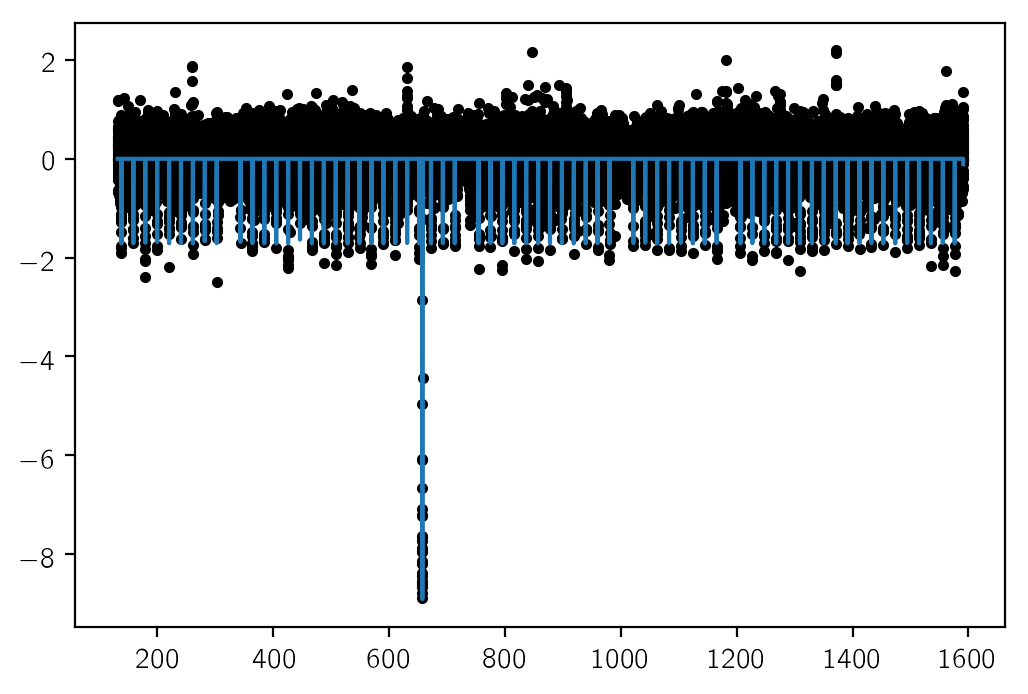

In [10]:
plt.plot(t[rng], y[rng], ".k")
plt.plot(t_tensor.eval(), transit_model.eval())

In [11]:
print(session.run(model.get_parameters()))
for i in range(3):
    opt.minimize(session)
print(session.run(model.get_parameters()))

[0.0, 0.6931471805599452, array([0., 0.]), -1.4547524087769572, 0.04869107476891266, 0.21330218091744868, array([-3.26848633, -2.44364187]), array([ 14.5478488, 657.26877  ]), array([0.51082562, 0.51082562]), array([-5.58347411, -4.64615924]), array([[ 0.64768854,  1.52302986],
       [-0.23415337, -0.23413696]])]
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -75180.216776
  Number of iterations: 28
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -75180.216776
  Number of iterations: 28
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -75180.219904
  Number of iterations: 2
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -75180.219904
  Number of iterations: 2
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -75180.219904
  Number of iterations: 0
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -75180.219904
  Number of iterations: 0
  Number of functions evaluations: 21


[0.010605856879125682, 0.30963341895451957, array([-0.00241069, -0.00096792]), -1.4820629637722749, 0.04821784456463832, 0.23565374811691117, array([-3.28821061, -2.45608206]), array([ 14.55983002, 657.26871202]), array([0.46658976, 0.51294635]), array([-5.58371825, -4.646152  ]), array([[ 0.64737874,  1.52316159],
       [-0.23418058, -0.23410975]])]


In [12]:
model.gradient(model.current_vector())

array([-2.34749105e+02,  7.17815045e+02, -8.66562591e+01, -4.11495342e+01,
       -1.11546730e+03,  1.53532434e+03, -5.51937181e+04, -5.11794462e+02,
        3.02616160e+02, -1.46914463e+03,  5.59894149e+01, -1.57649355e+03,
       -1.88644707e+02, -8.43353161e+00,  3.57023091e+00, -1.26480744e+01,
        3.57741032e+00, -5.78969368e+00,  6.25980638e+00])

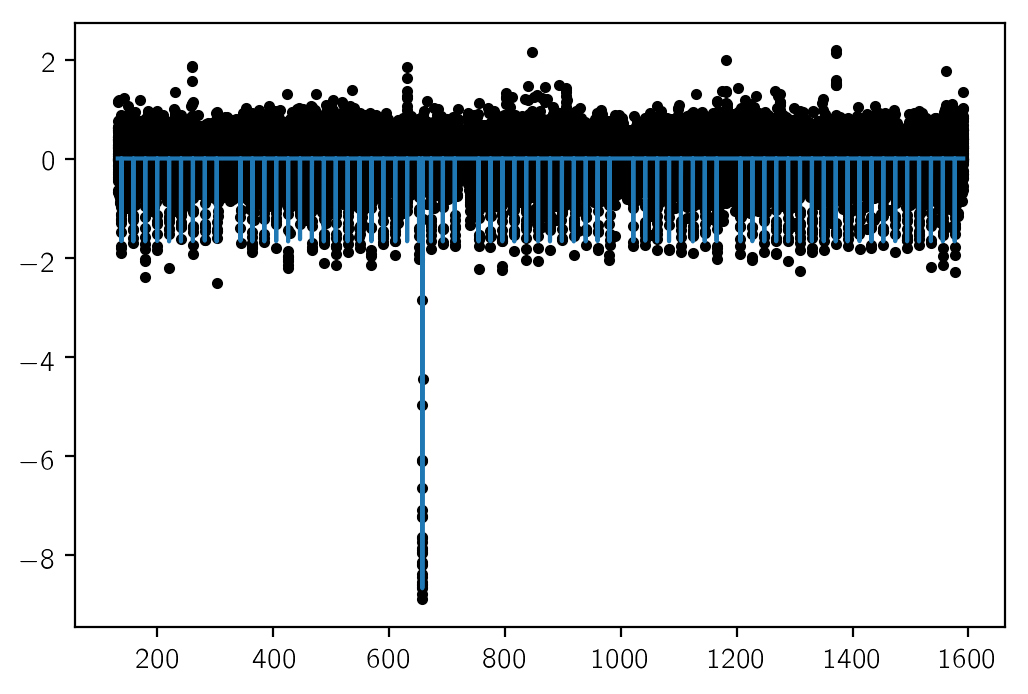

In [13]:
plt.plot(t[rng], y[rng], ".k")
plt.plot(t_tensor.eval(), transit_model.eval())
# plt.xlim(650, 670)

In [14]:
tf.exp(log_P).eval()

array([ 20.54958174, 977.34412263])

In [15]:
coords = model.current_vector()
ndim = len(coords)
print(ndim)

diag = np.empty(ndim)

eps = 1.234e-4
v0 = model.value(coords)
for n in range(ndim):
    coords[n] += eps
    vp = model.value(coords)
    coords[n] -= 2*eps
    vm = model.value(coords)
    coords[n] += eps
    
    diag[n] = eps**2 / np.abs(vp + vm - 2*v0)

19


In [16]:
diag

array([1.65249506e-06, 7.04711197e-05, 1.35547922e-02, 2.74574258e-02,
       1.13407624e-04, 1.09027151e-09, 4.92080364e-05, 2.00785897e-05,
       1.28211854e-05, 3.71361838e-07, 2.24991762e-06, 5.38468415e-05,
       3.92463210e-05, 1.03647975e-01, 1.96107563e-01, 1.42235960e-01,
       1.60127002e-01, 1.30225867e-02, 3.94373240e-02])

In [17]:
model.value(coords)
%timeit model.value(coords)

100 loops, best of 3: 5.71 ms per loop


In [18]:
model.gradient(coords)
%timeit model.gradient(coords)

100 loops, best of 3: 10.3 ms per loop


In [120]:
metric = hemcee.metric.DenseMetric(np.diag(diag))
sampler = hemcee.NoUTurnSampler(model.value, model.gradient, metric=metric)
results = sampler.run_warmup(coords, 10000, initial_buffer=1000, final_buffer=1000)

initial warm up: step_size: 2.4e-04; mean(accept_stat): 0.486: 100%|██████████| 1000/1000 [04:47<00:00,  3.58it/s]
warm up 1/9: step_size: 1.9e-04; mean(accept_stat): 0.477: 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]
warm up 2/9: step_size: 1.2e-04; mean(accept_stat): 0.362: 100%|██████████| 25/25 [00:05<00:00,  3.86it/s]
warm up 3/9: step_size: 8.0e-05; mean(accept_stat): 0.415: 100%|██████████| 50/50 [00:12<00:00,  3.80it/s]
warm up 4/9: step_size: 7.2e-05; mean(accept_stat): 0.446: 100%|██████████| 100/100 [00:24<00:00,  3.93it/s]
warm up 5/9: step_size: 8.1e-05; mean(accept_stat): 0.464: 100%|██████████| 200/200 [00:49<00:00,  3.91it/s]
warm up 6/9: step_size: 1.3e-04; mean(accept_stat): 0.475: 100%|██████████| 400/400 [01:39<00:00,  3.93it/s]
warm up 7/9: step_size: 1.5e-04; mean(accept_stat): 0.484: 100%|██████████| 800/800 [03:21<00:00,  3.93it/s]
warm up 8/9: step_size: 3.7e-04; mean(accept_stat): 0.489: 100%|██████████| 1600/1600 [06:49<00:00,  3.95it/s]
warm up 9/9: step

In [121]:
chain, lp_chain = sampler.run_mcmc(results[0], 5000)

step_size: 6.7e-04; mean(accept_stat): 0.733: 100%|██████████| 5000/5000 [22:42<00:00,  3.77it/s]


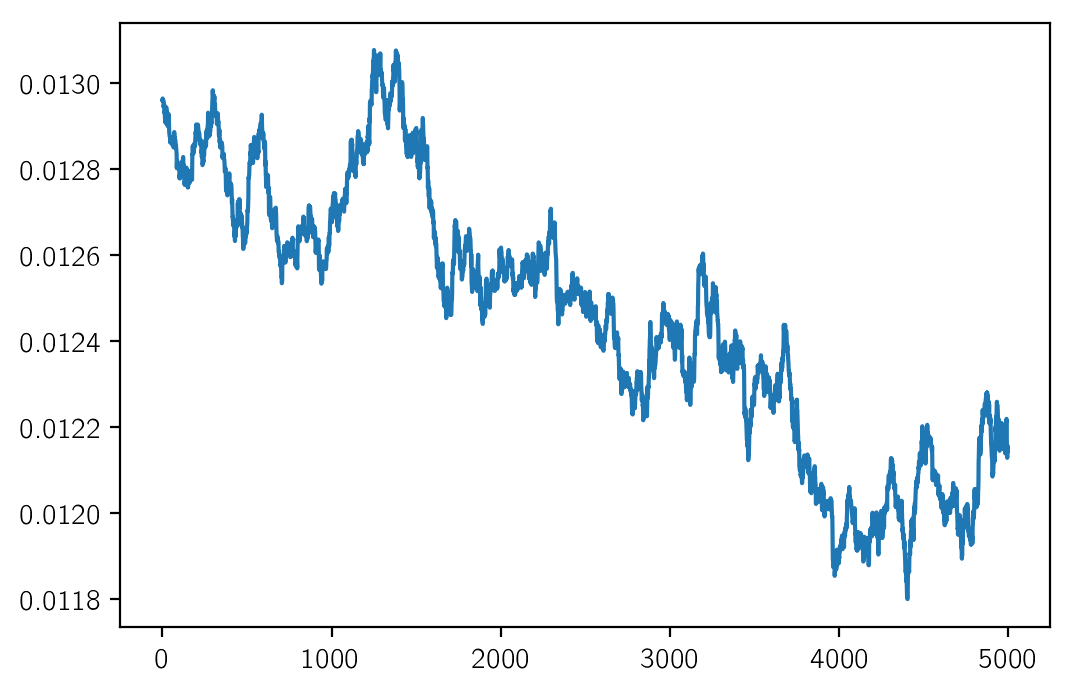

In [122]:
plt.plot(chain[:, 0]);

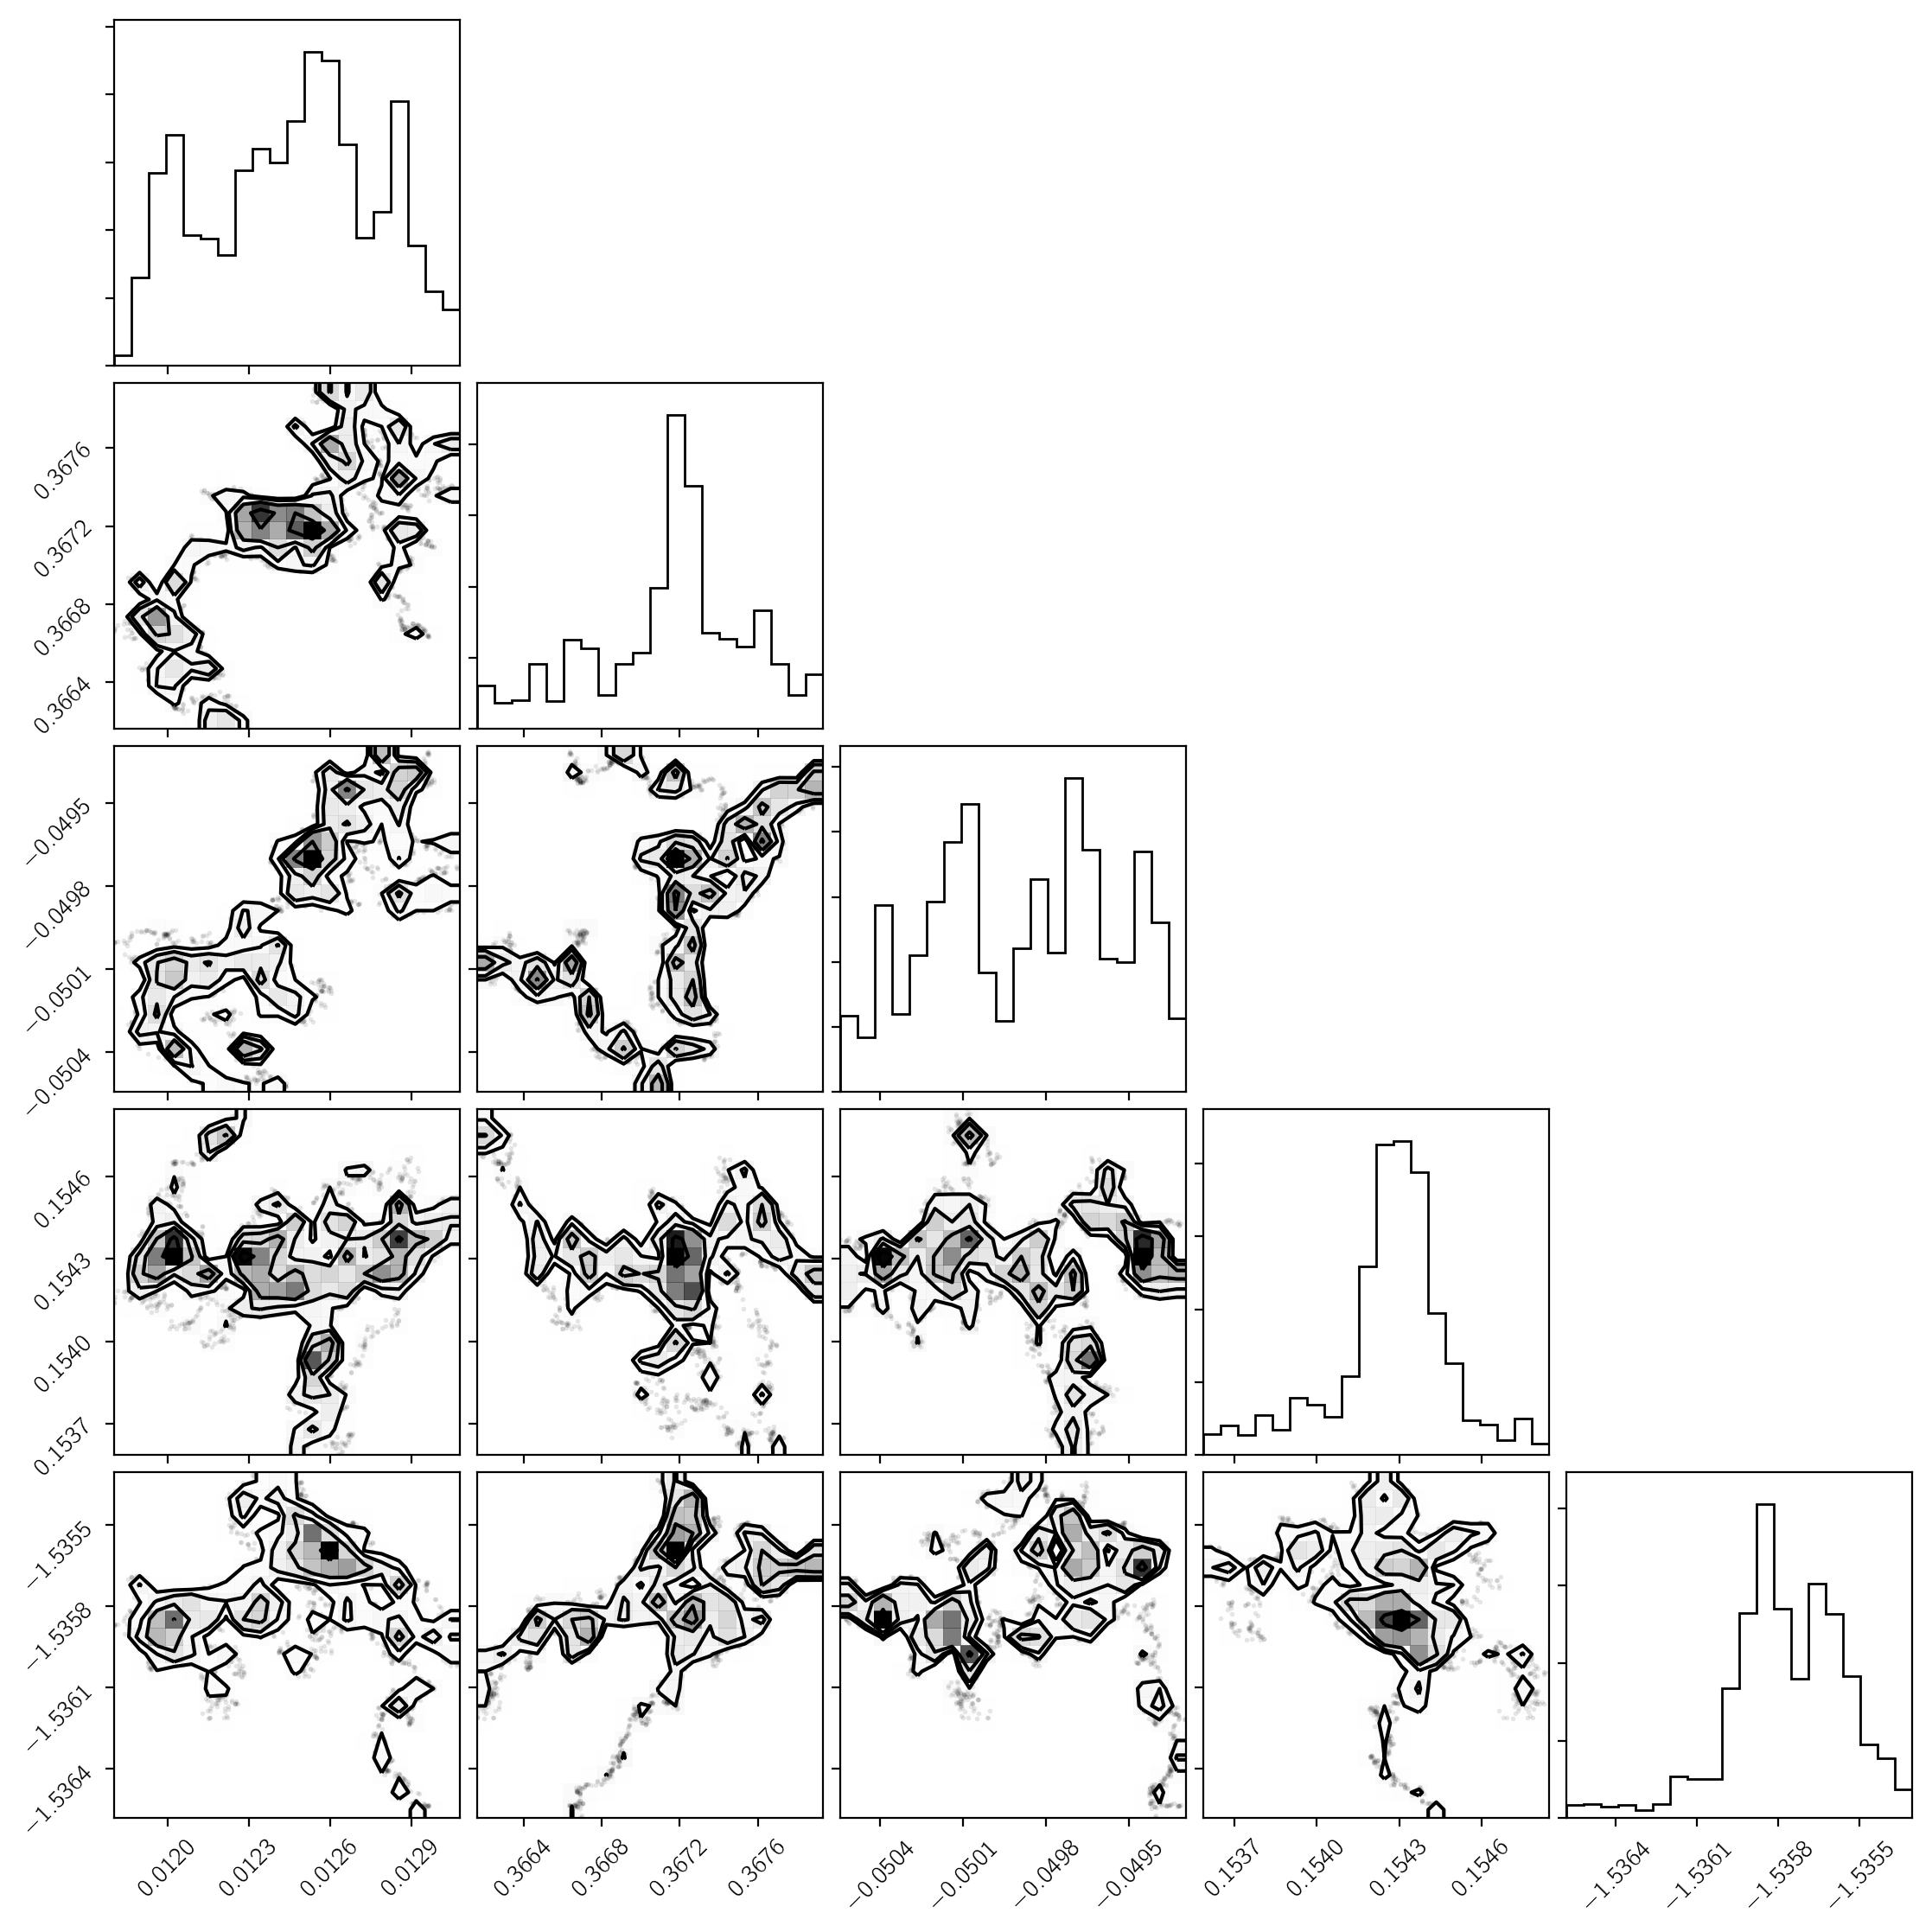

In [123]:
import corner
corner.corner(chain[:, :5]);

In [124]:
res = model.get_values_for_chain(chain, [log_rho_star.value], names=["log_rho"])

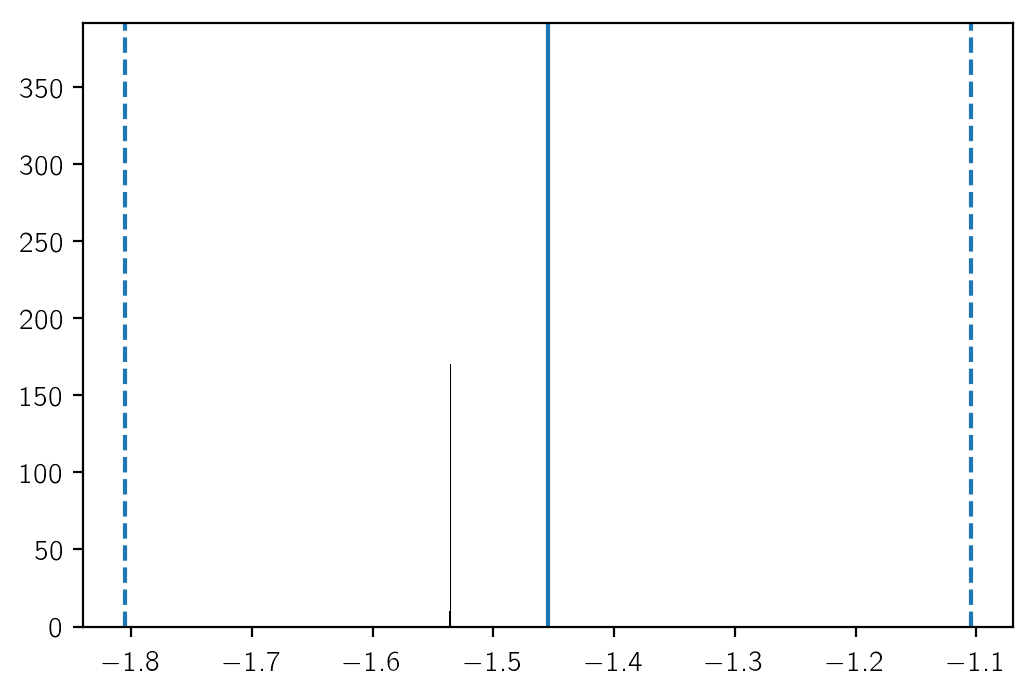

In [125]:
plt.hist(res["log_rho"], 50, color="k")
plt.axvline(log_dens[0])
plt.axvline(log_dens[0] + log_dens[1], linestyle="--")
plt.axvline(log_dens[0] - log_dens[1], linestyle="--");

In [126]:
res = model.get_values_for_chain(chain, [tf.exp(log_P)], names=["period"])

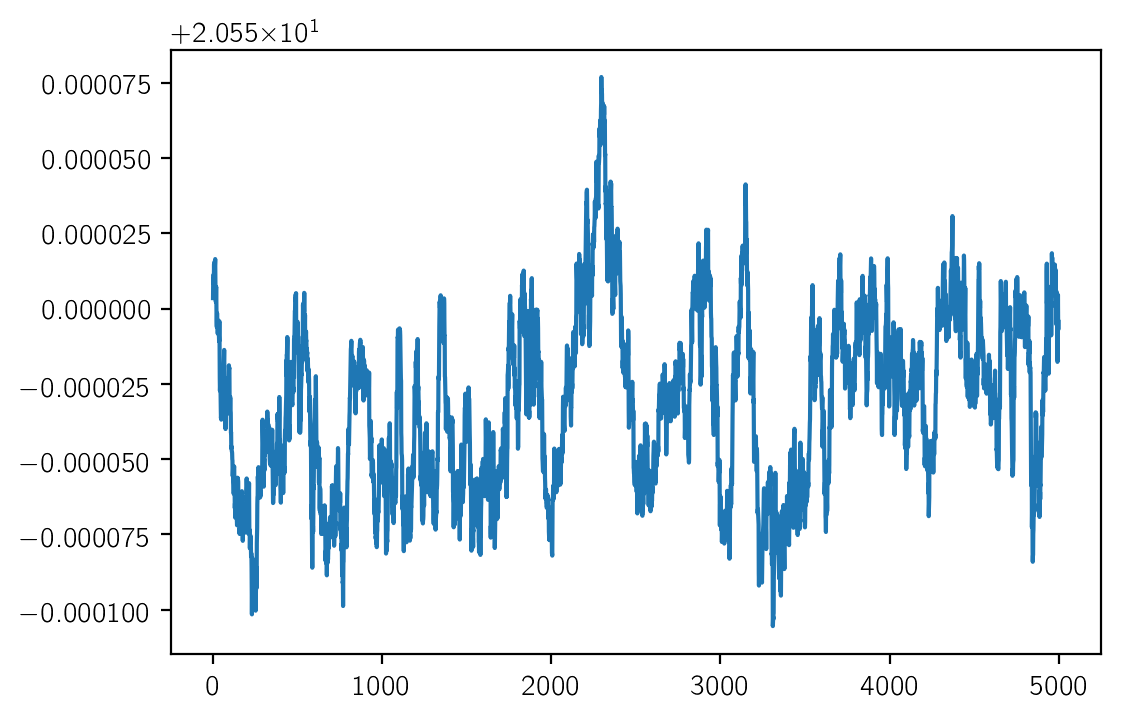

In [127]:
plt.plot(res["period"][:, 0])

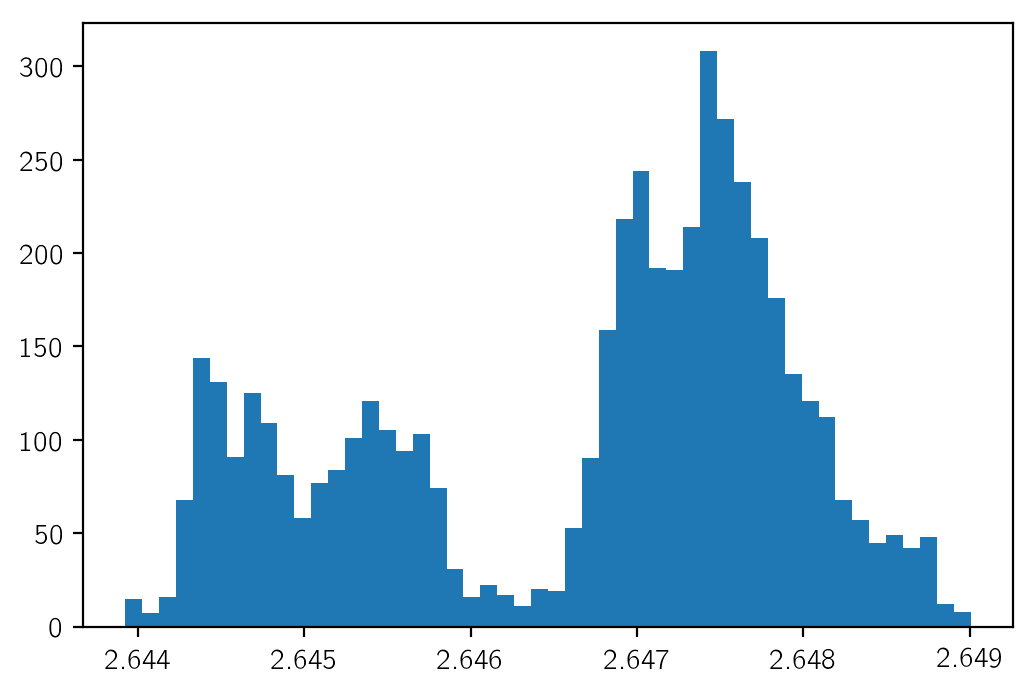

In [128]:
plt.hist(res["period"][:, -1] / 365.25, 50);

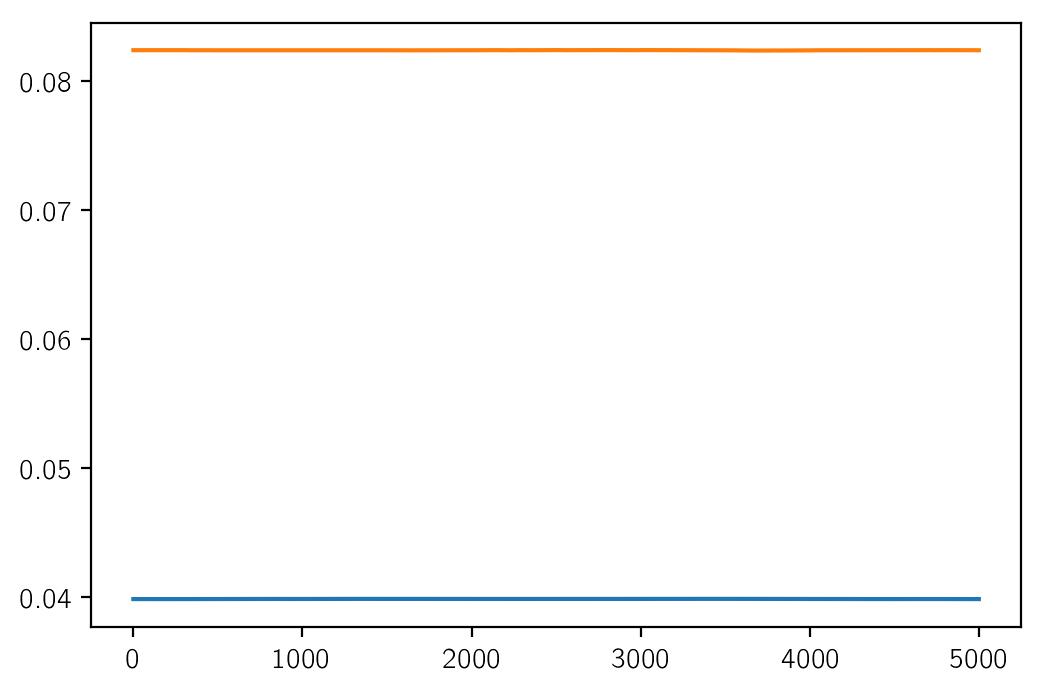

In [129]:
res = model.get_values_for_chain(chain, [e.value], names=["e"])
plt.plot(np.sqrt(res["e"]));

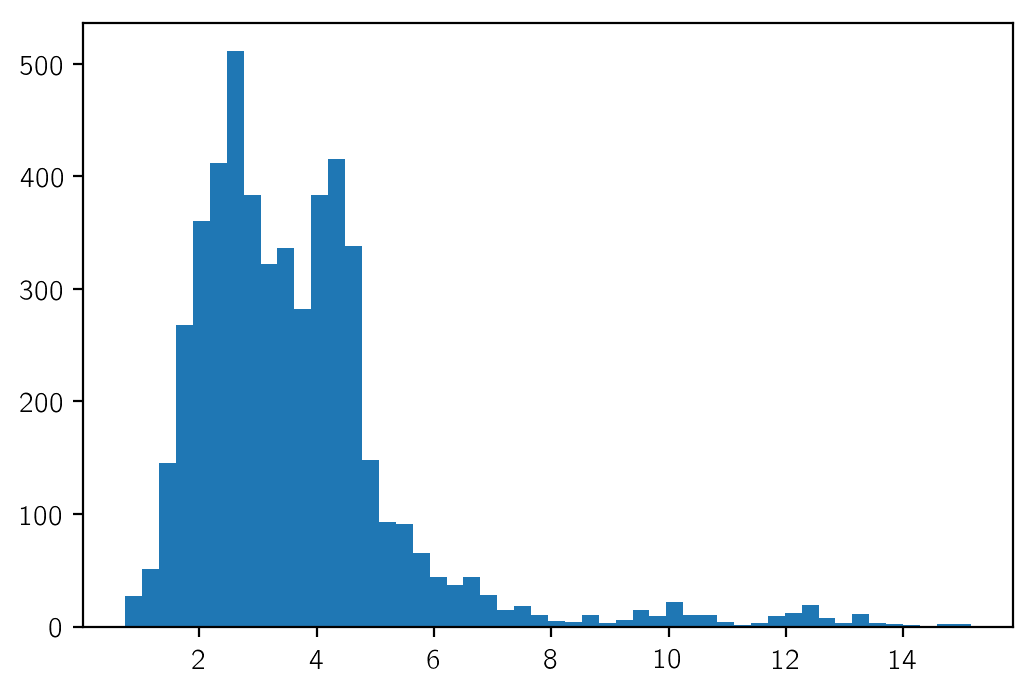

In [41]:
plt.hist(res["period"] / 365.25, 50);